https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py

Dataset is the raw RADAR data that has not been reshaped into chirps.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [0]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/wavenet/range_fft_bin_20/range_fft_MTI_100ms_shift.pkl'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint

Using TensorFlow backend.


In [0]:
with open(DATA_PATH, "rb") as file:
    data = pickle.load(file)

In [0]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [0]:
train_x = []
train_y = []
test_x = []
test_y = []
test_user = "A"
for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == test_user:
                    test_x.append(row)
                    test_y.append(convert_label_to_int(action))
                else:
                    train_x.append(row)
                    train_y.append(convert_label_to_int(action)) 
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)      

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

In [0]:
train_y = np_utils.to_categorical(train_y, nb_classes)
test_y = np_utils.to_categorical(test_y, nb_classes)

In [0]:
train_x = abs(train_x)
test_x = abs(test_x)

In [0]:
# Standard Parameters
epochs = 10
TRAIN_SAMPLES = train_x.shape[0]
VALID_SAMPLES = test_x.shape[0]
TEST_SAMPLES = test_x.shape[0]

In [0]:
n_filters = 40
dilation_depth = 4
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 32

In [0]:
# from https://github.com/mjpyeon/wavenet-classifier
class WaveNetClassifier():
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, n_filters=40, pool_size_1=80, pool_size_2=100, load=False, load_dir='./'):
        """
        Parameters:
          input_shape: (tuple) tuple of input shape. (e.g. If input is 6s raw waveform with sampling rate = 16kHz, (96000,) is the input_shape)
          output_shape: (tuple)tuple of output shape. (e.g. If we want classify the signal into 100 classes, (100,) is the output_shape)
          kernel_size: (integer) kernel size of convolution operations in residual blocks
          dilation_depth: (integer) type total depth of residual blocks
          n_filters: (integer) # of filters of convolution operations in residual blocks
          load: (bool) load previous WaveNetClassifier or not
          load_dir: (string) the directory where the previous model exists
        """      
        self.activation = 'softmax'
        self.scale_ratio = 1      
        self.pool_size_1 = pool_size_1
        self.pool_size_2 = pool_size_2

        # save input info
        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()
        self.input_shape = input_shape


        self.output_shape = output_shape

        # save hyperparameters of WaveNet
        self.kernel_size = kernel_size
        self.dilation_depth = dilation_depth
        self.n_filters = n_filters
        self.manual_loss = None


        if load is True:
            self.model = load_model(load_dir+"saved_wavenet_clasifier.h5", custom_objects={'tf':tf})
            self.prev_history = pd.read_csv(load_dir+'wavenet_classifier_training_history.csv')
            self.start_idx = len(self.prev_history)
            self.history = None
        else:
            self.model = self.construct_model()
            self.start_idx = 0
            self.history = None
            self.prev_history = None


    def residual_block(self, x, i):
        tanh_out = Conv1D(self.n_filters, 
                          self.kernel_size, 
                          dilation_rate = self.kernel_size**i, 
                          padding='causal', 
                          name='dilated_conv_%d_tanh' % (self.kernel_size ** i), 
                          activation='tanh'
                          )(x)
        sigm_out = Conv1D(self.n_filters, 
                          self.kernel_size, 
                          dilation_rate = self.kernel_size**i, 
                          padding='causal', 
                          name='dilated_conv_%d_sigm' % (self.kernel_size ** i), 
                          activation='sigmoid'
                          )(x)
        z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
        skip = Conv1D(self.n_filters, 1, name='skip_%d'%(i))(z)
        res = Add(name='residual_block_%d' % (i))([skip, x])
        return res, skip

    def construct_model(self):    
        x = Input(shape=self.input_shape, name='original_input')
        if self.expand_dims == True:
            x_reshaped = Reshape(self.input_shape + (1,), name='reshaped_input')(x)
        else:
            x_reshaped = x
        skip_connections = []
        out = Conv1D(self.n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x_reshaped)
        for i in range(1, self.dilation_depth + 1):
            out, skip = self.residual_block(out,i)
            skip_connections.append(skip)
        out = Add(name='skip_connections')(skip_connections)
        out = Activation('relu')(out)
        
        '''
        "For this task we added a mean-pooling layer after the dilated convolutions
        that agregated the activations to coarser frames spanning 10 milliseconds
        (160x downsampling). The pooling layer was followed by a few non-causal convolutions." - Wavenet Paper
        '''
        out = Conv1D(self.n_filters, self.pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
        out = AveragePooling1D(self.pool_size_1, padding='same', name='downsample_to_200Hz')(out)

        out = Conv1D(self.n_filters, self.pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
        out = Conv1D(self.output_shape[0], self.pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
        out = AveragePooling1D(self.pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
        out = Conv1D(self.output_shape[0], (int) (self.input_shape[0]/(self.pool_size_1*self.pool_size_2)), padding='same', name='final_conv')(out)
        out = AveragePooling1D((int) (self.input_shape[0]/(self.pool_size_1*self.pool_size_2)), name='final_pooling')(out)
        out = Reshape(self.output_shape)(out)
        out = Activation(self.activation)(out)
        if self.scale_ratio != 1:
            out = Lambda(lambda x: x * self.scale_ratio, name='output_reshaped')(out)
        model = Model(x, out)  
        model.summary()
        return model

    def get_model(self):
        return self.model

    def add_loss(self, loss):
        self.manual_loss = loss

    def fit(self, X, Y, validation_data = None, epochs = 100, batch_size = 32, optimizer='adam', save=False, save_dir='./'):
        # set default losses if not defined
        if self.manual_loss is not None:
            loss = self.manual_loss
            metrics = None
        else:
            loss = 'categorical_crossentropy'
            metrics = ['accuracy']

        # set callback functions
        if save:
            saved = save_dir + "saved_wavenet_clasifier.h5"
            hist = save_dir + 'wavenet_classifier_training_history.csv'
            if validation_data is None:
                checkpointer = ModelCheckpoint(filepath=saved, monitor='loss', verbose=1, save_best_only=True)
            else:
                checkpointer = ModelCheckpoint(filepath=saved, monitor='val_loss', verbose=1, save_best_only=True)
            history = History()
            callbacks = [history, checkpointer]
        else:
            callbacks = None

        # compile the model
        self.model.compile(optimizer, loss, metrics)
        try:
            self.history = self.model.fit(X, Y, shuffle = True, batch_size=batch_size, epochs = epochs, validation_data = validation_data, callbacks=callbacks, initial_epoch=self.start_idx)
        except:
            if save:
                df = pd.DataFrame.from_dict(history.history)
                df.to_csv(hist, encoding='utf-8', index=False)
            raise
            sys.exit()
        return self.history


    def predict(self, x):
        return self.model.predict(x)

dilation depth|      receptive field|     Val Accuracy after 10 epochs


---


9                            512                   0.767

8                            256

7                            128

6                            64

5                            32

4                            16                        0.896

3                            8


In [0]:
wnc = WaveNetClassifier((3000,), (7,), kernel_size = kernel_size,
                        dilation_depth = dilation_depth, n_filters = n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 3000)         0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 3000, 1)      0           original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 3000, 40)     120         reshaped_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 3000, 40)     3240        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_co

In [0]:
history = wnc.fit(train_x, train_y, validation_data = (test_x, test_y),
                  epochs = epochs, batch_size = batch_size, optimizer='adam',
                  save=False, save_dir='./')

Train on 37050 samples, validate on 7980 samples
Epoch 1/10
37050/37050 [==============================] - 147s 4ms/step - loss: 0.9928 - acc: 0.5740 - val_loss: 0.4960 - val_acc: 0.7584
Epoch 2/10
37050/37050 [==============================] - 143s 4ms/step - loss: 0.4417 - acc: 0.8253 - val_loss: 0.4101 - val_acc: 0.8053
Epoch 3/10
37050/37050 [==============================] - 144s 4ms/step - loss: 0.3314 - acc: 0.8739 - val_loss: 0.5697 - val_acc: 0.7959
Epoch 4/10
37050/37050 [==============================] - 143s 4ms/step - loss: 0.2671 - acc: 0.8983 - val_loss: 0.7511 - val_acc: 0.7460
Epoch 5/10
37050/37050 [==============================] - 142s 4ms/step - loss: 0.2042 - acc: 0.9236 - val_loss: 0.7985 - val_acc: 0.7941
Epoch 6/10
37050/37050 [==============================] - 142s 4ms/step - loss: 0.1460 - acc: 0.9461 - val_loss: 0.7024 - val_acc: 0.7944
Epoch 7/10
37050/37050 [==============================] - 142s 4ms/step - loss: 0.1281 - acc: 0.9526 - val_loss: 0.7800 - v

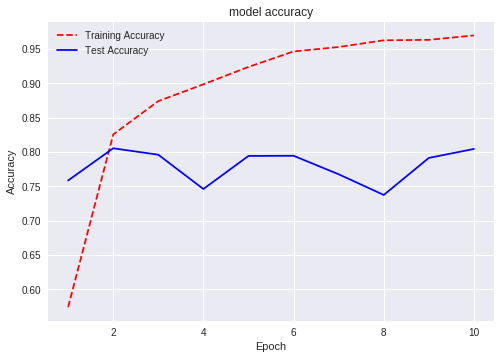

In [0]:
visualize.plot_train_test_acc(history=history)